In [1]:
import pandas as pd
import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
data_folder = Path("/content/drive/MyDrive/Airline")

In [4]:
aa_otp = pd.read_csv(data_folder/"AA_OTP.csv")
alaska_otp = pd.read_csv(data_folder/"Alaska_OTP.csv")
delta_otp = pd.read_csv(data_folder/"Delta_OTP.csv")
sw_otp = pd.read_csv(data_folder/"SouthWest_OTP.csv")
united_otp = pd.read_csv(data_folder/"United_OTP.csv")
aa = pd.read_excel(data_folder/"AA.xlsx").transpose()
alaska = pd.read_excel(data_folder/"Alaska.xlsx").transpose()
delta = pd.read_excel(data_folder/"Delta.xlsx").transpose()
sw = pd.read_excel(data_folder/"SouthWest.xlsx").transpose()
united = pd.read_excel(data_folder/"United.xlsx").transpose()

In [5]:
def rmvSpaceFromCol(df):
    newCol = []
    cols = df.columns
    for col in cols:
        newCol.append(re.sub(r'\s+','',col))
    df.columns = newCol

In [6]:
rmvSpaceFromCol(aa_otp)
rmvSpaceFromCol(alaska_otp)
rmvSpaceFromCol(delta_otp)
rmvSpaceFromCol(sw_otp)
rmvSpaceFromCol(united_otp)

In [7]:
aa_otp.columns

Index(['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name',
       'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
       'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
       'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay'],
      dtype='object')

In [8]:
aa_otp = aa_otp.iloc[:,[0,6,7]]
alaska_otp = alaska_otp.iloc[:,[0,6,7]]
delta_otp = delta_otp.iloc[:,[0,6,7]]
sw_otp = sw_otp.iloc[:,[0,6,7]]
united_otp = united_otp.iloc[:,[0,6,7]]

In [9]:
print(aa_otp.isna().sum())
print(alaska_otp.isna().sum())
print(delta_otp.isna().sum())
print(sw_otp.isna().sum())
print(united_otp.isna().sum())

year            0
arr_flights     4
arr_del15      11
dtype: int64
year           0
arr_flights    1
arr_del15      2
dtype: int64
year            0
arr_flights    53
arr_del15      63
dtype: int64
year           0
arr_flights    0
arr_del15      0
dtype: int64
year            0
arr_flights    22
arr_del15      35
dtype: int64


In [10]:
%%capture
aa_otp.fillna(aa_otp.median(), inplace=True)
alaska_otp.fillna(alaska_otp.median(), inplace=True)
delta_otp.fillna(delta_otp.median(), inplace=True)
sw_otp.fillna(sw_otp.median(), inplace=True)
united_otp.fillna(united_otp.median(), inplace=True)

In [11]:
aa_otp = aa_otp.groupby('year').sum()
alaska_otp = alaska_otp.groupby('year').sum()
delta_otp = delta_otp.groupby('year').sum()
sw_otp = sw_otp.groupby('year').sum()
united_otp = united_otp.groupby('year').sum()

In [12]:
aa_otp['airline'] = "aa"
alaska_otp['airline'] = "alaska"
delta_otp['airline'] = "delta"
sw_otp['airline'] = "sw"
united_otp['airline'] = "united"

In [13]:
otp = pd.concat([aa_otp, alaska_otp, delta_otp, sw_otp, united_otp])
otp['pc_delay'] = otp['arr_del15'] / otp['arr_flights'] * 100
pc_delay = otp['pc_delay']
otp = otp.drop(columns=['pc_delay'])
otp.insert(loc=2, column='pc_delay', value = pc_delay)
otp.reset_index(inplace=True)

In [14]:
otp = otp[(otp['year'] >= 2006) & (otp['year'] <= 2020)]
otp.columns = ['year','number_of_flights','number_of_delays','percent_delays','airline']

In [15]:
def clean_xlsx(df):
    df = df.reset_index(drop=True)
    df = df.iloc[13:,[1,146,148,159,189]]
    df.columns = ['year','total_fleet_cost','pilot_cost','maintenance_cost','ASM']
    df['total_fleet_cost'] = df['total_fleet_cost'] * 1000
    df['pilot_cost'] = df['pilot_cost'] * 1000
    df['maintenance_cost'] = df['maintenance_cost'] * 1000
    return df

In [16]:
aa = clean_xlsx(aa)
alaska = clean_xlsx(alaska)
delta = clean_xlsx(delta)
sw = clean_xlsx(sw)
united = clean_xlsx(united)

In [17]:
aa['airline'] = "aa"
alaska['airline'] = "alaska"
delta['airline'] = "delta"
sw['airline'] = "sw"
united['airline'] = "united"

In [18]:
cost = pd.concat([aa, alaska, delta, sw, united])

In [19]:
otp = otp.reset_index(drop=True)
cost = cost.reset_index(drop=True)

In [20]:
df = pd.merge(left=cost, right=otp, how="inner", on=['year','airline'])

In [21]:
df['CASM_Total'] = df['total_fleet_cost'] / df['ASM']
df['CASM_Pilot'] = df['pilot_cost'] / df['ASM']
df['CASM_Maintenance'] = df['maintenance_cost'] / df['ASM']

In [22]:
df.sample(3)

,year,total_fleet_cost,pilot_cost,maintenance_cost,ASM,airline,number_of_flights,number_of_delays,percent_delays,CASM_Total,CASM_Pilot,CASM_Maintenance
61,2007,9052920000,1131894000,1939497000,141900231111,united,490002.0,132461.0,27.032747,0.063798,0.007977,0.013668
11,2017,16599835000,4242071000,3698781000,243824198011,aa,896348.0,162026.0,18.076238,0.068081,0.017398,0.01517
55,2016,9158586000,2601835000,1654864000,148657618865,sw,1299444.0,230611.0,17.746898,0.061609,0.017502,0.011132


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 74
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               75 non-null     object 
 1   total_fleet_cost   75 non-null     object 
 2   pilot_cost         75 non-null     object 
 3   maintenance_cost   75 non-null     object 
 4   ASM                75 non-null     object 
 5   airline            75 non-null     object 
 6   number_of_flights  75 non-null     float64
 7   number_of_delays   75 non-null     float64
 8   percent_delays     75 non-null     float64
 9   CASM_Total         75 non-null     object 
 10  CASM_Pilot         75 non-null     object 
 11  CASM_Maintenance   75 non-null     object 
dtypes: float64(3), object(9)
memory usage: 7.6+ KB


In [24]:
for var in df.columns:
    if df[var].dtype == 'O' and var != 'airline':
        df[var] = df[var].astype(float)

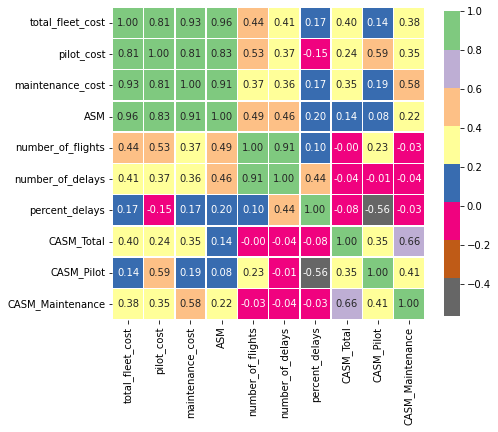

In [25]:
corrmat = df.drop(columns=['year','airline']).corr().round(2)
top_corr_features = corrmat.index
plt.figure(figsize=(7, 7))
sns.heatmap(corrmat,annot=True, square=True, fmt='.2f', cbar_kws={"shrink": .80}, linewidths=.5, cmap='Accent_r')
plt.show()

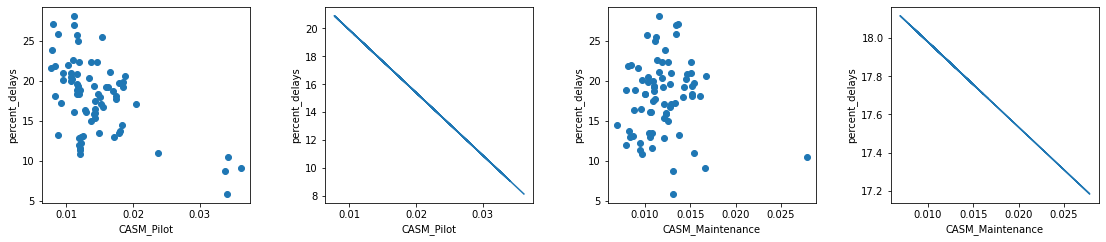

Slope CASM_Pilot - -448.438188415727 
Slope CASM_Maintenance - -44.483947878071184


In [26]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.plot(df['CASM_Pilot'], df['percent_delays'], 'o') # 'o' for scatter plot
plt.xlabel("CASM_Pilot")
plt.ylabel("percent_delays")
plt.subplot(1, 4, 2)
m, b = np.polyfit(df['CASM_Pilot'],df['percent_delays'], 1)
plt.plot(df['CASM_Pilot'], m * df['CASM_Pilot'] + b)
plt.xlabel("CASM_Pilot")
plt.ylabel("percent_delays")
plt.subplot(1, 4, 3)
plt.plot(df['CASM_Maintenance'], df['percent_delays'], 'o') # 'o' for scatter plot
plt.xlabel("CASM_Maintenance")
plt.ylabel("percent_delays")
plt.subplot(1, 4, 4)
m1, b1 = np.polyfit(df['CASM_Maintenance'], df['percent_delays'], 1)
plt.plot(df['CASM_Maintenance'], m1 * df['CASM_Maintenance'] + b1)
plt.xlabel("CASM_Maintenance")
plt.ylabel("percent_delays")
plt.tight_layout(pad=3)
plt.show()
print(f'Slope CASM_Pilot - {m} \nSlope CASM_Maintenance - {m1}')